In [15]:
# Import the standard modules
import sqlite3

# Import the installed modules
import pandas as pd
import numpy as np

# Import matplotlib for plotting
from matplotlib import pyplot as plt

In [16]:
# Connect to the comet database. This database has been created in tutorial
# part 7, however, due to its small size the database is uploaded on GitHub
con = sqlite3.connect('../databases/comets/mpc_comets.db')


In [17]:
# What kind of comet types are in the database? Let's check:
type_stats_df = \
    pd.read_sql('SELECT ORBIT_TYPE, COUNT(ORBIT_TYPE) FROM comets_main GROUP BY ORBIT_TYPE', con)
print(type_stats_df)

  ORBIT_TYPE  COUNT(ORBIT_TYPE)
0          A                 12
1          C                255
2          I                  2
3          P                661


In [18]:
# We have C, P, A and I comets in there.
#     C: Orbital Period >200 years
#     P: Orbital Persio <200 years + 2 of more perihelion passage observations
#     A: Actually an asteroid...
#     I: ??? -> Let see:
pd.read_sql('SELECT * FROM comets_main WHERE ORBIT_TYPE = "I"', con)

,NAME,ORBIT_TYPE,PERIHELION_AU,SEMI_MAJOR_AXIS_AU,APHELION_AU,ECCENTRICITY,INCLINATION_DEG,ARG_OF_PERIH_DEG,LONG_OF_ASC_NODE_DEG,MEAN_ANOMALY_DEG,EPOCH_UTC,EPOCH_ET,ABSOLUTE_MAGNITUDE,SLOPE_PARAMETER
0,1I/`Oumuamua,I,0.255240,None,None,1.199252,122.6778,241.6845,24.5997,0.0,2017-9-9T11:43:35,5.582295e+08,23.0,2.0
1,2I/Borisov,I,2.006548,None,None,3.356636,44.0527,209.1251,308.1480,0.0,2019-12-8T13:19:03,6.290832e+08,11.0,4.0


In [19]:
# Create a pandas dataframe that contains the aphelion and inclination data
# for P type ...
p_type_df = pd.read_sql('SELECT APHELION_AU, INCLINATION_DEG ' \
                        'FROM comets_main WHERE ORBIT_TYPE="P"', con)

# ... and C type comets. For this type: include also the eccentricity
c_type_df = pd.read_sql('SELECT APHELION_AU, INCLINATION_DEG, ECCENTRICITY ' \
                        'FROM comets_main WHERE ORBIT_TYPE="C"', con)

In [20]:
# Print some descriptive statistics of the P type comets
#print('Descriptive statistics of P comets')
p_type_df.describe()

,APHELION_AU,INCLINATION_DEG
count,661.000000,661.000000
mean,7.794412,16.334095
std,6.429265,19.819588
min,2.441678,0.234600
25%,5.166490,7.357500
50%,5.932604,11.613000
75%,9.053838,18.921300
max,100.555831,172.534100


In [21]:
# Print some descriptive statistics of the C type comets (differentiate
# between bound (e<1) and un-bound (e>=1) comets)
c_type_df.loc[c_type_df["ECCENTRICITY"]<1].describe()

,APHELION_AU,INCLINATION_DEG,ECCENTRICITY
count,167.000000,167.000000,167.000000
mean,4584.621130,81.874649,0.954286
std,13546.416841,46.926214,0.097389
min,14.505238,3.149000,0.185325
25%,110.598307,42.441500,0.959205
50%,522.248789,81.410600,0.992225
75%,2763.499207,122.012900,0.997903
max,122138.273346,174.582700,0.999953


In [22]:
print(f'{c_type_df.loc[c_type_df["ECCENTRICITY"]>=1].describe()}')

       APHELION_AU  INCLINATION_DEG  ECCENTRICITY
count          0.0        88.000000     88.000000
mean           NaN        95.003128      1.001822
std            NaN        40.651600      0.003042
min            NaN        14.572600      1.000000
25%            NaN        66.283075      1.000380
50%            NaN        90.427850      1.001078
75%            NaN       128.567075      1.002209
max            NaN       167.036100      1.025958


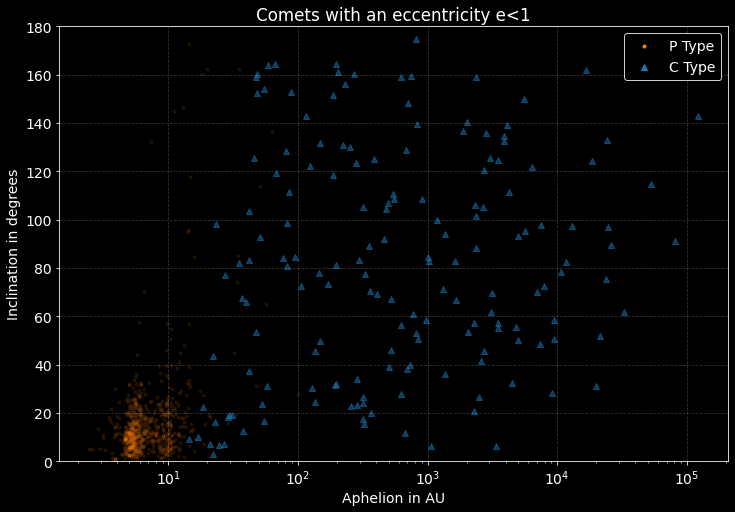

In [23]:
# We plot the Inclination data vs. the aphelion data to determine differences
# between P and C comets

# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

# Set a figure with a certain figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot of the P type comet inclination vs. the aphelion
ax.scatter(p_type_df['APHELION_AU'], \
           p_type_df['INCLINATION_DEG'], \
           marker='.', color='tab:orange', alpha=0.1, label='P Type')

# Scatter plot of the C type comet inclination vs. the aphelion (consider
# only the bound orbits!)
ax.scatter(c_type_df[c_type_df['ECCENTRICITY'] < 1]['APHELION_AU'], \
           c_type_df[c_type_df['ECCENTRICITY'] < 1]['INCLINATION_DEG'], \
           marker='^', color='tab:blue', alpha=0.5, label='C Type')

# The aphelion data vary between a few AU and hundreds of AU. We convert the
# x scale to a log10 scale
ax.set_xscale('log')

# Set a limit for the inclination; between 0 and 180 degrees
ax.set_ylim(0, 180)

# Set a grid for better readability
ax.grid(axis='both', linestyle='dashed', alpha=0.2)

# Set a title, and labels for the x and y axis
ax.set_title('Comets with an eccentricity e<1')
ax.set_xlabel('Aphelion in AU')
ax.set_ylabel('Inclination in degrees')

# Now we set a legend. However, the marker opacity in the legend has the
# same value as in the plot. A value of 0.1 would be difficult to see ...
leg = ax.legend(fancybox=True, loc='upper right', framealpha=1)

# ... thus, we set the markers' opacity to 1 with this small code
for lh in leg.legendHandles:
    lh.set_alpha(1)

# Save the plot in high quality
plt.savefig('comets_scatter_plot_Q_i.png', dpi=300)